#Preliminary: Updated Data Loading

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22,
 'figure.titlesize': 24 }
pylab.rcParams.update(params)

## Loading the dataset

In [85]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

Please load the raw csv data


Saving data_HW3.csv to data_HW3.csv


In [86]:
dataset = pd.read_csv(filename)

In [87]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def count_symptoms(symptoms):
    symptoms_list = symptoms.split(';')
    return len(symptoms_list) if symptoms_list != [''] else 0


def prepare_data(training_data, new_data):
    # Copy the data to avoid modifying the original
    data_preprocessed = new_data.copy()
    training_preprocessed = training_data.copy()
    # Create Special property
    training_preprocessed['SpecialProperty'] = training_preprocessed['blood_type'].isin(['O+', 'B+']).astype(int)
    training_preprocessed.drop('blood_type', axis=1, inplace=True)
    data_preprocessed['SpecialProperty'] = data_preprocessed['blood_type'].isin(['O+', 'B+']).astype(int)
    data_preprocessed.drop('blood_type', axis=1, inplace=True)

    # Create num_symptoms
    # Replace NaN with empty strings
    training_preprocessed['symptoms'] = training_preprocessed['symptoms'].fillna('').astype(str)
    data_preprocessed['symptoms'] = data_preprocessed['symptoms'].fillna('').astype(str)
    # Count the number of symptoms each patient has
    training_preprocessed['num_of_symptoms'] = training_preprocessed['symptoms'].apply(count_symptoms)
    data_preprocessed['num_of_symptoms'] = data_preprocessed['symptoms'].apply(count_symptoms)
    # Drop the 'symptoms' column
    training_preprocessed.drop('symptoms', axis=1, inplace=True)
    data_preprocessed.drop('symptoms', axis=1, inplace=True)

    # Change sex to be 1/0
    training_preprocessed['sex'] = training_preprocessed['sex'].map({'M': 0, 'F': 1})
    data_preprocessed['sex'] = data_preprocessed['sex'].map({'M': 0, 'F': 1})

    # Remove patient id
    training_preprocessed.drop('patient_id', axis=1, inplace=True)
    data_preprocessed.drop('patient_id', axis=1, inplace=True)

    # Handle date - transform it number of days since 0000-01-01
    training_preprocessed['pcr_date'] = pd.to_datetime(training_preprocessed['pcr_date'])
    data_preprocessed['pcr_date'] = pd.to_datetime(data_preprocessed['pcr_date'])
    # Extract year, month, and day
    #training_preprocessed['pcr_year'] = training_preprocessed['pcr_date'].dt.year
    #training_preprocessed['pcr_month'] = training_preprocessed['pcr_date'].dt.month
    #training_preprocessed['pcr_day'] = training_preprocessed['pcr_date'].dt.dayofweek

    #data_preprocessed['pcr_year'] = data_preprocessed['pcr_date'].dt.year
    #data_preprocessed['pcr_month'] = data_preprocessed['pcr_date'].dt.month
    #data_preprocessed['pcr_day'] = data_preprocessed['pcr_date'].dt.dayofweek

    # Remove the original `pcr_date`
    training_preprocessed.drop('pcr_date', axis=1, inplace=True)
    data_preprocessed.drop('pcr_date', axis=1, inplace=True)

    # Split 'current_location' into 'latitude' and 'longitude'
    training_preprocessed[['latitude', 'longitude']] = training_preprocessed['current_location'].str.strip(
        "()").str.replace("'", "").str.split(',', expand=True).astype(float)
    data_preprocessed[['latitude', 'longitude']] = data_preprocessed['current_location'].str.strip("()").str.replace(
        "'", "").str.split(',', expand=True).astype(float)

    # Remove the original 'current_location' column
    training_preprocessed.drop('current_location', axis=1, inplace=True)
    data_preprocessed.drop('current_location', axis=1, inplace=True)

    # normalize chosen columns
    columns_to_standardize = ['longitude', 'latitude', 'weight', 'num_of_siblings', 'happiness_score',
                              'household_income', 'conversations_per_day', 'sugar_levels', 'sport_activity',
                              'num_of_symptoms', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'PCR_04']
    columns_to_minmax = ['age', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_05', 'PCR_06']

    # Standardize columns
    scaler_standard = StandardScaler().fit(training_preprocessed[columns_to_standardize])
    data_preprocessed[columns_to_standardize] = scaler_standard.transform(data_preprocessed[columns_to_standardize])
    # MinMax scale columns
    scaler_minmax = MinMaxScaler(feature_range=(-1,1)).fit(training_preprocessed[columns_to_minmax])
    data_preprocessed[columns_to_minmax] = scaler_minmax.transform(data_preprocessed[columns_to_minmax])

    return data_preprocessed

In [88]:
from sklearn.model_selection import train_test_split

random_state = 76+57

# Split the dataset into training and test sets
train, test = train_test_split(dataset, test_size=0.2, random_state=random_state)

#Prepare training set according to itself
train_df_prepared = prepare_data(train, train)

# Prepare test set according to the raw training set
test_df_prepared = prepare_data(train, test)


# Section 1: Linear regression implementation

**Explore the data, analysis**

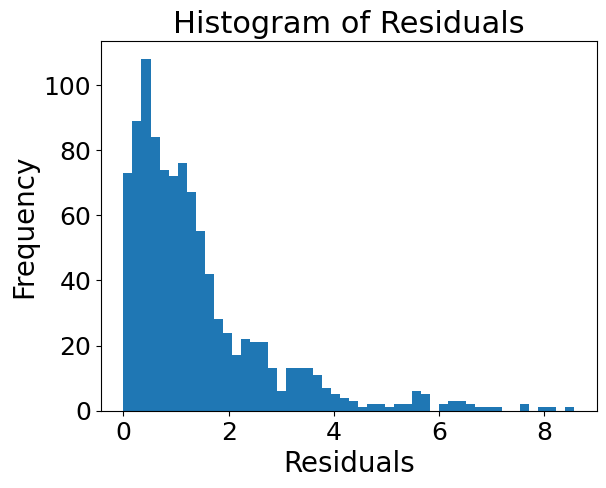

Number of outliers: 67


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import median_abs_deviation

y = train_df_prepared['contamination_level']
X = train_df_prepared.drop(columns=['contamination_level'])
regressor = LinearRegression()
regressor.fit(X, y)
y_pred = regressor.predict(X)


residuals = np.abs(y_pred - y)

# Plot histogram of residuals
plt.hist(residuals, bins=50)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


# Calculate Q1 (25th percentile) and Q3 (75th percentile) using quantiles
Q1 = np.quantile(residuals, 0.25)
Q3 = np.quantile(residuals, 0.75)
# Calculate the IQR by subtracting Q1 from Q3
IQR = Q3 - Q1
max= Q3+1.5*IQR
arr = [r > max for r in residuals]
IQR = Q3 - Q1

# Determine the outlier bounds
upper_bound = Q3 + 1.5 * IQR

# Find any outliers in the dataset
outliers = residuals > upper_bound

# Count the number of outliers
number_of_outliers = np.sum(outliers)

print(f'Number of outliers: {number_of_outliers}')


**(Q3) Method for create huber delta based on data**

In [90]:
def calculate_huber_delta(X, y):
    regressor = LinearRegression()
    regressor.fit(X, y)
    y_pred = regressor.predict(X)

    residuals = np.abs(y_pred - y)
    Q1 = np.quantile(residuals, 0.25)
    Q3 = np.quantile(residuals, 0.75)
    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5 * IQR

    delta = upper_bound
    delta = round(delta , 2)
    return delta

In [91]:
from sklearn.linear_model import LinearRegression
#derive delta0 by all the data because we want to use it in the entire exs
y= train_df_prepared['contamination_level']
X = train_df_prepared.drop(columns=['contamination_level'])
huber_delta0 = calculate_huber_delta(X, y)
print(huber_delta0)

3.65


**Create Linear Regression model with huber loss**

In [92]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np


class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5, huber_delta: float = 1.0):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0
        self.huber_delta = huber_delta

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y, huber_delta: float):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        residuals = X.dot(w) + b - y

        indicator_smaller_than_delta = (np.abs(residuals) <= huber_delta)

        # sign * is np.multiply so we calc the squared loss for every row and than we choose just relevant rows with residuals smaller than delta
        squared_loss = np.sum(0.5 * (residuals ** 2) * indicator_smaller_than_delta)

        indicator_bigger_than_delta = (1 - indicator_smaller_than_delta)
        # sign * is np.multiply so we calc the linear loss for every row and than we choose just relevant rows with residuals bigger than delta
        linear_loss= np.sum((huber_delta * (np.abs(residuals) - 0.5 * huber_delta)) * (indicator_bigger_than_delta))

        num_rows = X.shape[0]

        loss = (squared_loss + linear_loss)/num_rows
        return loss

    @staticmethod
    def gradient(w, b: float, X, y, huber_delta: float):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        residuals = X.dot(w) + b - y
        sign_residuals = np.sign(residuals)

        indicator_smaller_than_delta = (np.abs(residuals) <= huber_delta)
        squared_loss_gradient_w = X.T @ (residuals * indicator_smaller_than_delta)

        indicator_bigger_than_delta = (1 - indicator_smaller_than_delta)
        linear_loss_gradient_w=  huber_delta*(X.T @ (sign_residuals * indicator_bigger_than_delta))

        squared_loss_gradient_b= np.dot(residuals.T, indicator_smaller_than_delta)
        linear_loss_gradient_b = huber_delta*np.dot(sign_residuals.T, indicator_bigger_than_delta)

        num_rows = X.shape[0]
        g_w = (squared_loss_gradient_w + linear_loss_gradient_w)/num_rows
        g_b = (squared_loss_gradient_b + linear_loss_gradient_b)/num_rows

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y, self.huber_delta))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val, self.huber_delta))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y, self.huber_delta)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w -= self.lr*g_w
            self.b -= self.lr*g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y, self.huber_delta))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val, self.huber_delta))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = X.dot(self.w) + self.b

        return y_pred

In [93]:
def numerical_subgradient(w, b, X, y, huber_delta: float, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y, huber_delta) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, huber_delta: float, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y, huber_delta)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, huber_delta, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


**Create train + validation pre processed again because we need to normalize validation alone**

In [94]:
random_state = 76+57

# Split the dataset into training and test sets
train_regression_pre, validation_regression_pre = train_test_split(train, test_size=0.2, random_state=random_state)
#Prepare training set according to itself
train_regression= prepare_data(train_regression_pre, train_regression_pre)

# Prepare test set according to the raw training set
validation_regression = prepare_data(train_regression_pre, validation_regression_pre)

y_train_regression= train_regression['contamination_level']
X_train_regression= train_regression.drop(columns=['contamination_level'])
X_train_regression = X_train_regression.to_numpy()
y_train_regression = y_train_regression.to_numpy()

y_validation_regression= validation_regression['contamination_level']
X_validation_regression= validation_regression.drop(columns=['contamination_level'])
X_validation_regression = X_validation_regression.to_numpy()
y_validation_regression = y_validation_regression.to_numpy()

huber_delta0_section1 = calculate_huber_delta(X_train_regression, y_train_regression)

In [95]:
train['contamination_level'].describe()

count    1.000000e+03
mean     1.286634e+00
std      2.297802e+00
min      4.786004e-10
25%      6.984398e-04
50%      1.353992e-02
75%      1.836883e+00
max      1.123468e+01
Name: contamination_level, dtype: float64

**(Q4)**

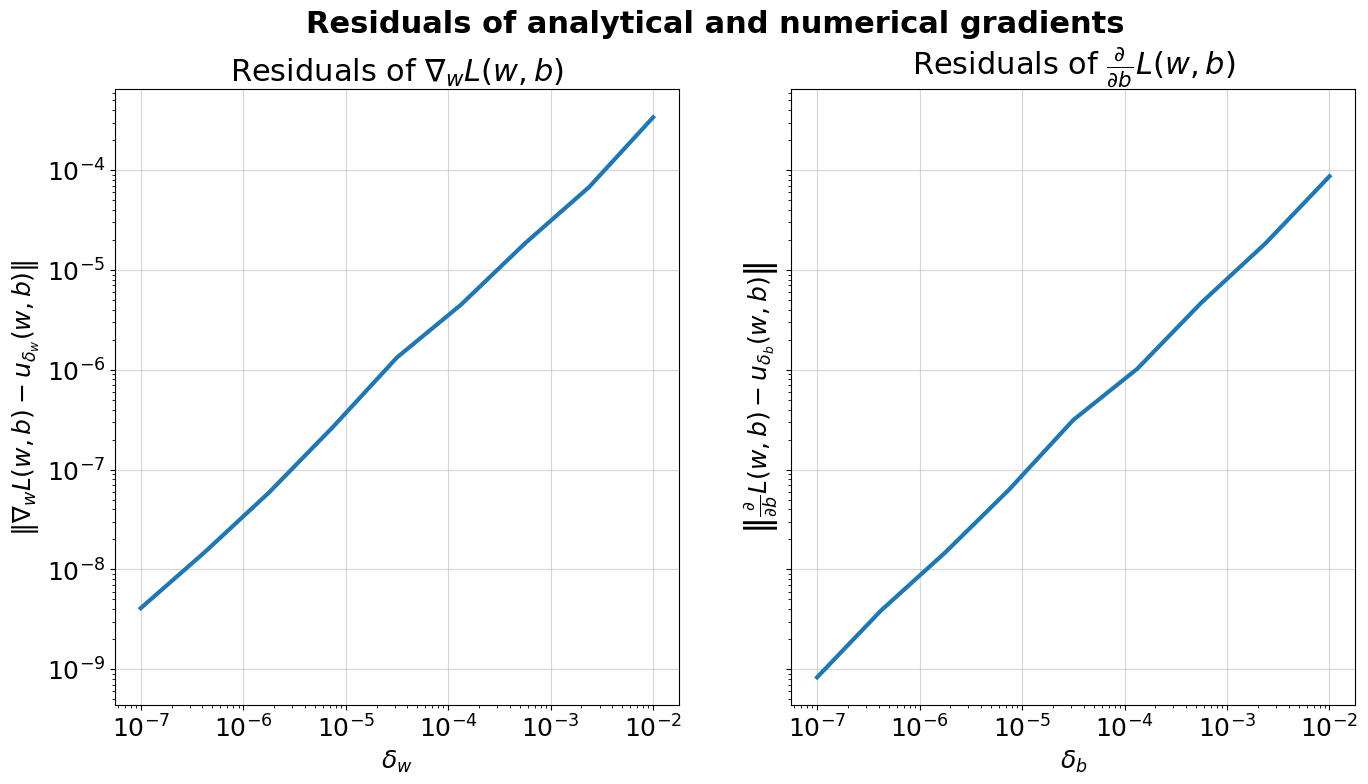

In [96]:
huber_delta= 0.1
compare_gradients(X_train_regression, y_train_regression, huber_delta, deltas=np.logspace(-7, -2, 9))

**(Q5)**

In [97]:
import matplotlib.pyplot as plt
import numpy as np


def test_lr(X_train, y_train, X_val, y_val, huber_delta: float, title: str, max_iter: int = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr, huber_delta)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter=max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = ' + str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('Huber')

3.67
lr size = 1e-09, Best train loss = 2.7334116928427057, Best validation loss = 2.8412847051491483
lr size = 1e-08, Best train loss = 2.7333829368806644, Best validation loss = 2.8412570681780074
lr size = 1e-07, Best train loss = 2.733095425956277, Best validation loss = 2.8409807450955653
lr size = 1e-06, Best train loss = 2.730225180064165, Best validation loss = 2.838222171209404
lr size = 1e-05, Best train loss = 2.7020037286137715, Best validation loss = 2.8110966775118684
lr size = 0.0001, Best train loss = 2.4630655382430633, Best validation loss = 2.5811136231045926
lr size = 0.001, Best train loss = 1.7936389925792062, Best validation loss = 1.9460638201448983
lr size = 0.01, Best train loss = 1.7032865612495616, Best validation loss = 1.9079213367460992
lr size = 0.1, Best train loss = 1.704883246285381, Best validation loss = 1.8984495945936815


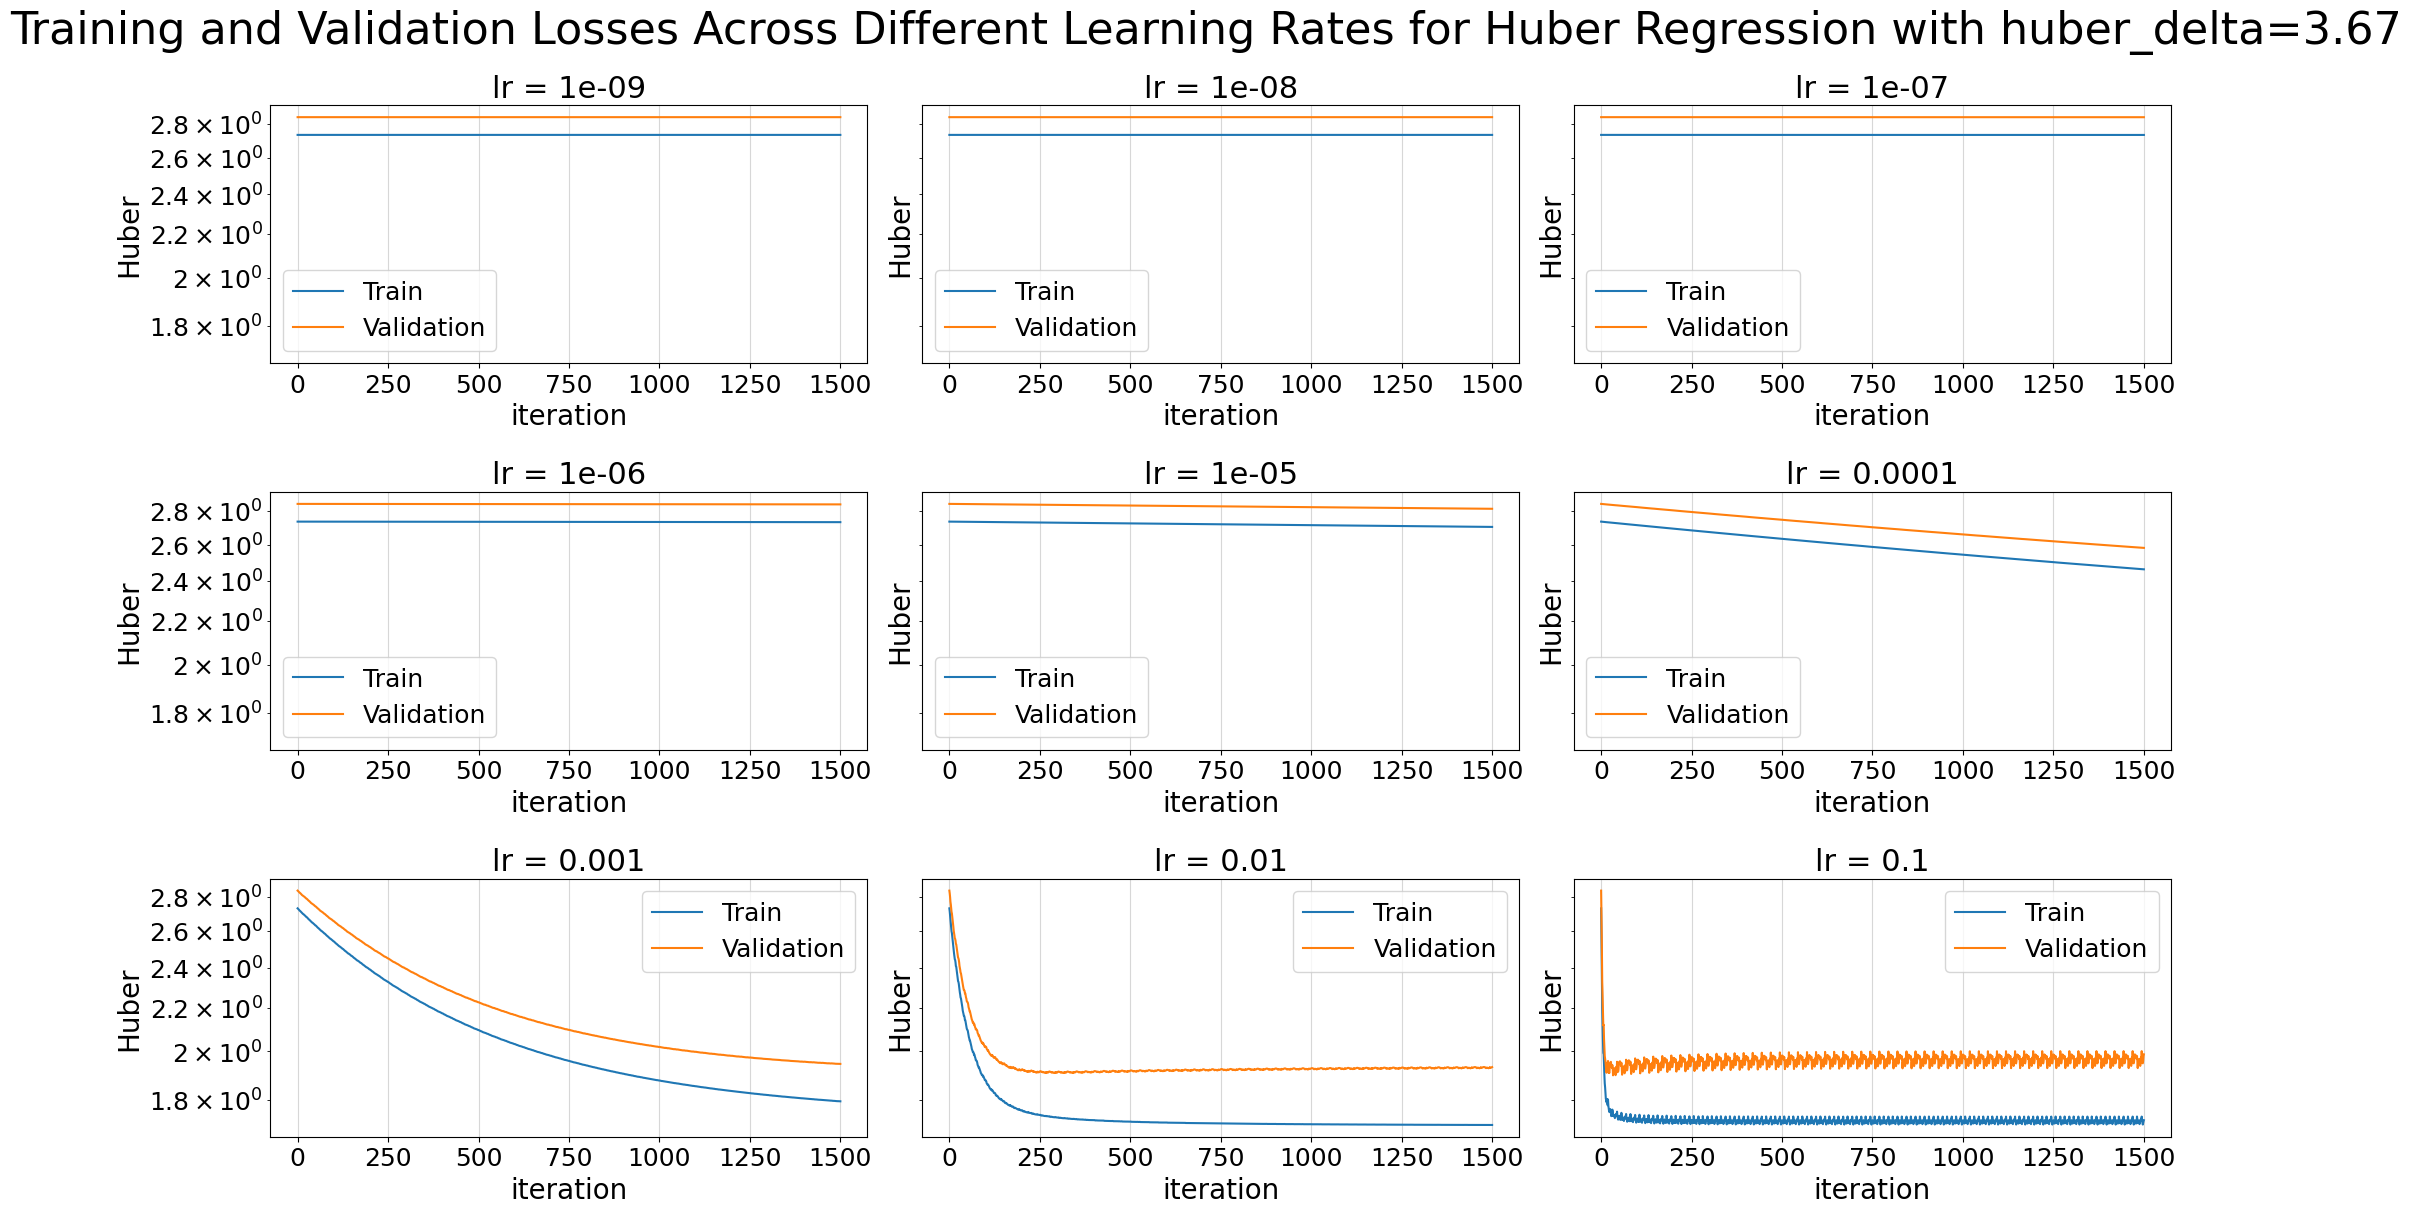

In [98]:
print(huber_delta0_section1)
test_lr(X_train_regression, y_train_regression, X_validation_regression, y_validation_regression, huber_delta0_section1, f"Training and Validation Losses Across Different Learning Rates for Huber Regression with huber_delta={huber_delta0_section1}")

# Section 2: Evaluation and Baseline

In [ ]:
print(train.shape)
train.head()

(1000, 25)


,patient_id,age,sex,weight,blood_type,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,...,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,contamination_level
256,34,29,F,56.6,A+,"('7.65649', '4.92235')",2,9,2.0,3,...,-3.252399,91.991738,-5.700317,112.850913,-28.973380,1.600888,8.105269,1.019798,0.799955,3.771095e-02
351,1246,48,F,69.6,O+,"('34.25628', '-78.04471')",0,8,2.0,7,...,28.576247,-90.340184,-4.748222,204.938217,30.441790,3.442616,4.273379,0.905969,8.842312,3.371572e-09
348,810,28,M,80.9,AB+,"('41.72059', '-87.70172')",1,9,1.0,13,...,28.393817,-90.372167,-6.575695,151.530975,-6.217022,4.124909,5.127900,-2.789673,6.333419,1.286884e-08
109,725,16,M,54.3,A+,"('33.35283', '-111.78903')",1,10,3.0,8,...,-10.902092,-51.014912,-10.508345,28.369077,7.504367,4.333476,5.161051,-8.534867,-6.303868,3.748732e+00
1093,861,10,M,30.6,O+,"('10.63504', '-85.43772')",0,8,2.0,2,...,-12.739470,96.431075,-1.417134,285.079071,26.341355,5.932142,2.562992,7.322826,-10.928784,1.173532e-09


In [ ]:
print(test.shape)
test.head()

(250, 25)


,patient_id,age,sex,weight,blood_type,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,...,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,contamination_level
338,64,32,M,63.7,AB+,"('30.81383', '75.16878')",3,8,1.0,2,...,8.938053,-28.525776,-3.066184,6.909364,-24.464104,8.321351,3.367999,4.294328,-0.343139,0.013073
317,1428,36,F,58.9,B+,"('1.6561', '103.6032')",3,8,5.0,4,...,-8.991597,45.899343,-4.489888,37.510143,-25.176731,1.463748,5.279459,-0.052976,-0.500633,0.040557
175,1775,26,M,85.2,A-,"('-10.91722', '-37.65')",0,10,4.0,6,...,0.129350,79.356405,-8.210405,83.833534,8.159295,3.052037,5.359259,-3.622788,-7.022402,5.365238
559,705,24,F,49.6,O+,"('54.60528', '18.34717')",0,10,2.0,8,...,-33.599395,-60.845284,-2.755419,171.549273,-15.940668,1.419308,2.774952,5.392342,1.881530,0.687192
810,1978,32,F,75.6,B+,"('36.20829', '-115.98391')",1,10,2.0,2,...,7.496652,77.456896,-5.700782,334.023620,-9.937948,6.956010,4.905921,0.926439,-6.194421,3.686905


In [ ]:
#Prepare training set according to itself
train_df_prepared = prepare_data(train, train)

# Prepare test set according to the raw training set
test_df_prepared = prepare_data(train, test)

y_train_section2 = train_df_prepared['contamination_level']
X_train_section2= train_df_prepared.drop(columns=['contamination_level'])
y_train_section2 = y_train_section2.to_numpy()
X_train_section2= X_train_section2.to_numpy()

y_test_section2 = test_df_prepared['contamination_level']
X_test_section2= test_df_prepared.drop(columns=['contamination_level'])
y_test_section2= y_test_section2.to_numpy()
X_test_section2= X_test_section2.to_numpy()

**(Q7)**

In [ ]:
from sklearn.metrics import make_scorer
import numpy as np

def huber_loss_metric(y_true, y_pred, delta):
    residual = np.abs(y_true - y_pred)
    condition = residual <= delta
    squared_loss = 0.5 * (residual ** 2)
    linear_loss = delta * (residual - 0.5 * delta)
    huber_loss = np.where(condition, squared_loss, linear_loss)
    return np.mean(huber_loss)

def get_huber_scorer(delta=1.0):
    return make_scorer(huber_loss_metric, greater_is_better=False, delta=delta)


In [ ]:
print(huber_delta0)

3.65


In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
import numpy as np

dummy_regr = DummyRegressor(strategy="mean") ## save it for future use(SEC6)
scoring_metrics = {'MSE': 'neg_mean_squared_error', 'Huber': get_huber_scorer(huber_delta0)}
scores = cross_validate(dummy_regr, X_train_section2, y_train_section2 , cv=5, scoring=scoring_metrics , return_train_score=True)
-1*scores['train_MSE']

array([5.52247314, 5.53744196, 5.31207451, 4.83953212, 5.15149577])

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
import numpy as np

dummy_regr = DummyRegressor(strategy="mean")
scoring_metrics = {'MSE': 'neg_mean_squared_error', 'Huber': get_huber_scorer(huber_delta0)}
scores = cross_validate(dummy_regr, X_train_section2, y_train_section2 , cv=5, scoring=scoring_metrics , return_train_score=True)

training_mse_scores = -1 * scores['train_MSE']
training_mean_mse_score = np.mean(training_mse_scores)
training_mse_std = np.std(training_mse_scores)

training_huber_scores = -1 * scores['train_Huber']
training_mean_huber_score = np.mean(training_huber_scores)
training_huber_std = np.std(training_huber_scores)

validation_scores = -1 * scores['test_MSE']
validation_mean_score = np.mean(validation_scores)
validation_std= np.std(validation_scores)
dummy_regressor_validation_mse = round(validation_mean_score,2)
print(f"DummyRegressor Results: Training huber score: {training_mean_huber_score:.2f} (+/- {training_huber_std :.2f})")
print(f"DummyRegressor Results: Training MSE score: {training_mean_mse_score:.2f} (+/- {training_mse_std :.2f})")
print(f"DummyRegressor Results: Validation MSE: {validation_mean_score:.2f} (+/- {validation_std:.2f})")


DummyRegressor Results: Training huber score: 2.29 (+/- 0.10)
DummyRegressor Results: Training MSE score: 5.27 (+/- 0.26)
DummyRegressor Results: Validation MSE: 5.29 (+/- 1.05)


In [99]:
from sklearn.metrics import mean_squared_error
#### (Q20) ######
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_section2, y_train_section2)   #piazza @252 the scores you got from training on all of the data

y_train_pred = dummy_regr.predict(X_train_section2)
y_test_pred = dummy_regr.predict(X_test_section2)

error_train_mse = mean_squared_error(y_train_section2, y_train_pred)
error_test_mse = mean_squared_error(y_test_section2, y_test_pred)

print(f"Training MSE: {error_train_mse}")
print(f"Test MSE: {error_test_mse}")

Training MSE: 5.274615581852823
Test MSE: 5.160304602563259


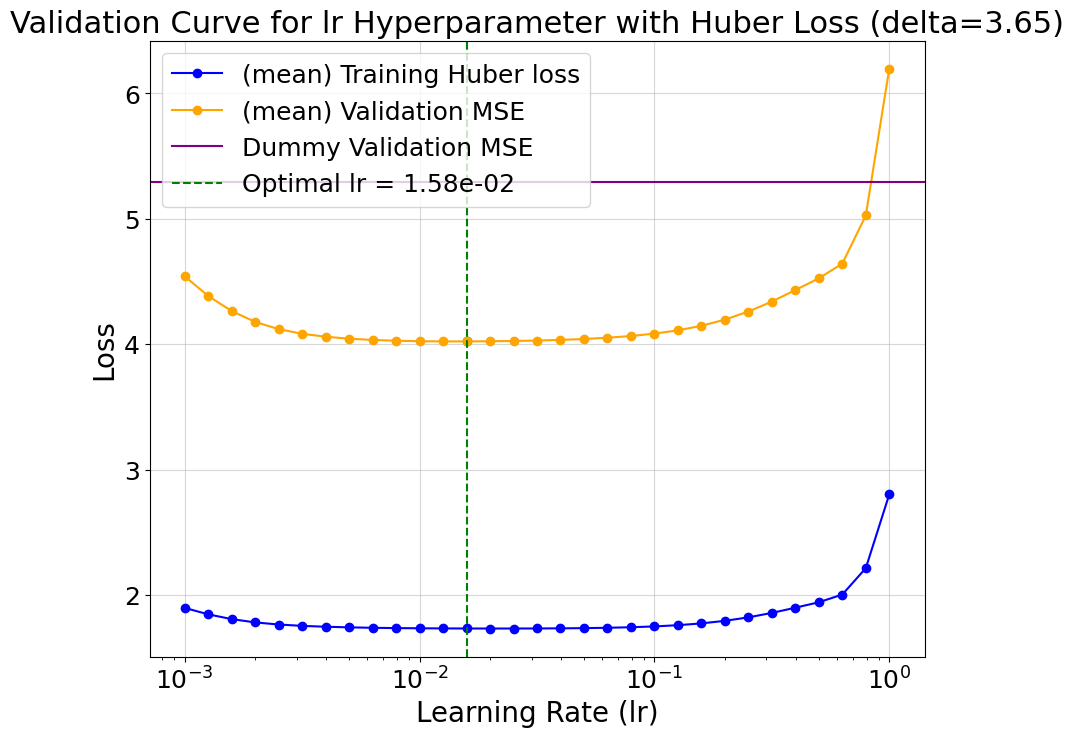

Optimal learning rate: 0.02
Training Huber loss at optimal lr: 1.73(+/- 0.10)
Validation MSE at optimal lr: 4.02(+/- 1.00)
[2.99803919 2.86744578 4.04861964 5.50994683 4.68658027]


In [105]:
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt

lr_values = lr_values = np.logspace(-3, 0, num=31)
best_lr = None
lowest_validation_mse = float('inf')
best_training_huber_loss = None
std_train_best= None
std_val_best = None
scores_validation_best = None

train_mean_huber_scores = []
train_mean_mse_scores = []
validation_mse_scores = []

scoring_metrics = {'MSE': 'neg_mean_squared_error', 'Huber': get_huber_scorer(huber_delta0)}

# Evaluate models for each learning rate value
for lr in lr_values:
    model = LinearRegressor(lr, huber_delta0)
    scores = cross_validate(model, X_train_section2, y_train_section2, cv=5,
                            scoring=scoring_metrics, return_train_score=True)

    train_huber_score = np.mean(-1 * scores['train_Huber'])
    train_mean_huber_scores.append(train_huber_score)

    train_mse_score = np.mean(-1 * scores['train_MSE'])
    train_mean_mse_scores.append(train_mse_score)

    validation_mse_score = np.mean(-1 * scores['test_MSE'])
    validation_mse_scores.append(validation_mse_score)

    # Update the best lr if the current validation MSE is lower than the previous lowest
    if validation_mse_score < lowest_validation_mse:
        best_lr = lr
        lowest_validation_mse = validation_mse_score
        best_training_huber_loss = train_huber_score
        std_train_best = np.std(-1 * scores['train_Huber'])
        std_val_best = np.std(-1 * scores['test_MSE'])
        scores_validation_best = -1 * scores['test_MSE']

# Plot the validation curve
plt.figure(figsize=(10, 8))
plt.semilogx(lr_values, train_mean_huber_scores, label='(mean) Training Huber loss',color='blue', marker='o')
plt.semilogx(lr_values, validation_mse_scores, label='(mean) Validation MSE', color='orange', marker='o')

plt.axhline(y=dummy_regressor_validation_mse, color='purple', label='Dummy Validation MSE')
plt.axvline(x=best_lr, color='green', linestyle='--', label=f'Optimal lr = {best_lr:.2e}')
plt.scatter([best_lr], [lowest_validation_mse], color='green')

plt.title(f'Validation Curve for lr Hyperparameter with Huber Loss (delta={huber_delta0})')
plt.xlabel('Learning Rate (lr)')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

print(f"Optimal learning rate: {best_lr:.2f}")
print(f"Training Huber loss at optimal lr: {best_training_huber_loss:.2f}(+/- {std_train_best:.2f})")
print(f"Validation MSE at optimal lr: {lowest_validation_mse:.2f}(+/- {std_val_best:.2f})")
print(scores_validation_best)

In [106]:
from sklearn.metrics import mean_squared_error

# Retrain with best hyperparameter
lr = 0.02

#### (Q20) ######
custom_LinearRegressor = LinearRegressor(lr, huber_delta0)
custom_LinearRegressor.fit(X_train_section2, y_train_section2)

y_train_pred = custom_LinearRegressor.predict(X_train_section2)
y_test_pred = custom_LinearRegressor.predict(X_test_section2)

error_train_huber = huber_loss_metric(y_train_section2, y_train_pred, huber_delta0)

error_train_mse = mean_squared_error(y_train_section2, y_train_pred)

error_test_mse = mean_squared_error(y_test_section2, y_test_pred)

print(f"Training Huber Loss: {error_train_huber}")
print(f"Training MSE: {error_train_mse}")
print(f"Test MSE: {error_test_mse}")


Training Huber Loss: 1.7413252762600608
Training MSE: 3.862187702806783
Test MSE: 3.748605086090574


# Section 3: Ridge linear regression

In [107]:
#Prepare training set according to itself
train_df_prepared = prepare_data(train, train)

# Prepare test set according to the raw training set
test_df_prepared = prepare_data(train, test)

y_train_section3 = train_df_prepared['contamination_level']
X_train_section3= train_df_prepared.drop(columns=['contamination_level'])
y_train_section3 = y_train_section3.to_numpy()
X_train_section3= X_train_section3.to_numpy()

y_test_section3 = test_df_prepared['contamination_level']
X_test_section3= test_df_prepared.drop(columns=['contamination_level'])
y_test_section3= y_test_section3.to_numpy()
X_test_section3= X_test_section3.to_numpy()

In [108]:
print(huber_delta0)

3.65


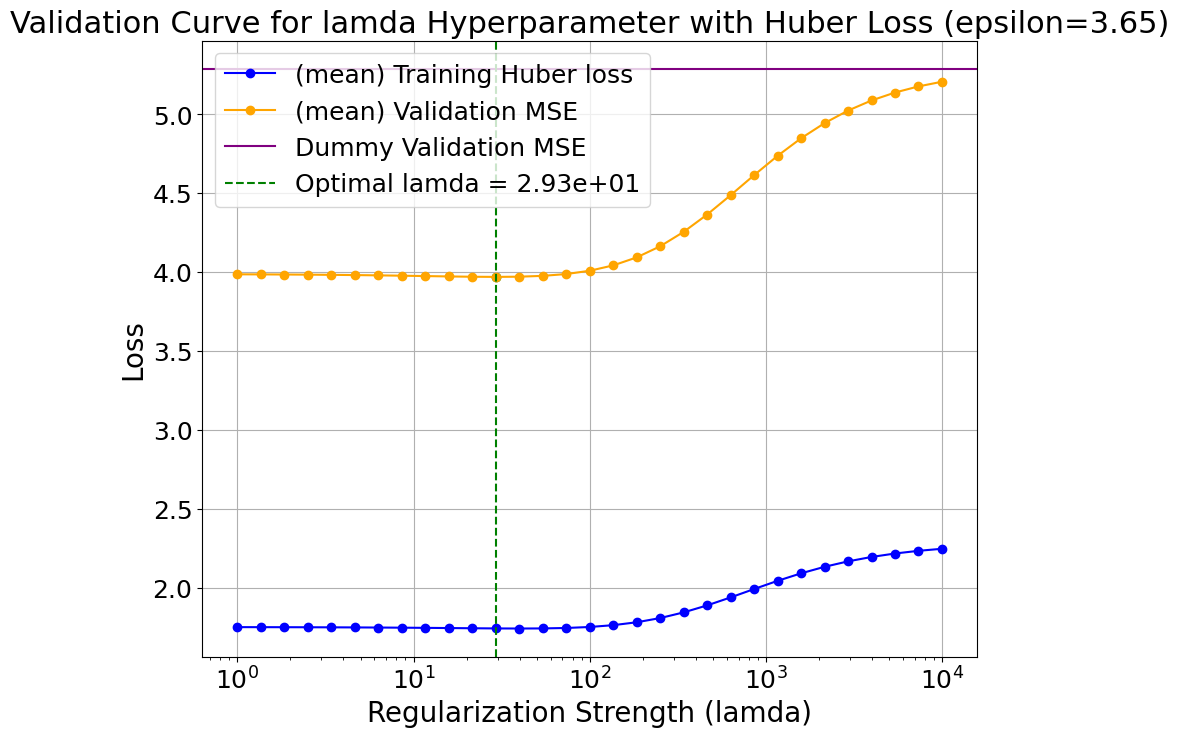

Optimal regularization strength (lamda): 2.93e+01
Training Huber loss at optimal lamda: 1.74(+/- 0.10)
Validation MSE at optimal lamda: 3.97(+/- 0.95)
[2.99180683 2.81297034 4.06160609 5.28246954 4.69686715]


In [110]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import HuberRegressor
import numpy as np
import matplotlib.pyplot as plt

lamda_values = np.logspace(0, 4, num=31)
best_lamda = None
lowest_validation_mse = float('inf')
best_training_huber_loss = None
std_train_best = None
std_val_best = None
scores_validation_best = None

train_mean_huber_scores = []
train_mean_mse_scores = []
validation_mse_scores = []

scoring_metrics = {'MSE': 'neg_mean_squared_error', 'Huber': get_huber_scorer(huber_delta0)}

# Evaluate models for each lamda value
for lamda in lamda_values:
    model = HuberRegressor(alpha=lamda, epsilon=huber_delta0, fit_intercept=True)
    scores = cross_validate(model, X_train_section3, y_train_section3, cv=5,
                            scoring=scoring_metrics, return_train_score=True)

    train_huber_score = np.mean(-1 * scores['train_Huber'])
    train_mean_huber_scores.append(train_huber_score)

    train_mse_score = np.mean(-1 * scores['train_MSE'])
    train_mean_mse_scores.append(train_mse_score)

    validation_mse_score = np.mean(-1 * scores['test_MSE'])
    validation_mse_scores.append(validation_mse_score)


    if validation_mse_score <= lowest_validation_mse:
        best_lamda = lamda
        lowest_validation_mse = validation_mse_score
        best_training_huber_loss = train_huber_score
        std_train_best = np.std(-1 * scores['train_Huber'])
        std_val_best = np.std(-1 * scores['test_MSE'])
        scores_validation_best = -1 * scores['test_MSE']

# Plot the validation curve
plt.figure(figsize=(10, 8))
plt.semilogx(lamda_values, train_mean_huber_scores, label='(mean) Training Huber loss', color='blue', marker='o')
plt.semilogx(lamda_values, validation_mse_scores, label='(mean) Validation MSE', color='orange', marker='o')

plt.axhline(y=dummy_regressor_validation_mse, color='purple', label='Dummy Validation MSE')
plt.axvline(x=best_lamda, color='green', linestyle='--', label=f'Optimal lamda = {best_lamda:.2e}')
plt.scatter([best_lamda], [lowest_validation_mse], color='green')

plt.title(f'Validation Curve for lamda Hyperparameter with Huber Loss (epsilon={huber_delta0})')
plt.xlabel('Regularization Strength (lamda)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal regularization strength (lamda): {best_lamda:.2e}")
print(f"Training Huber loss at optimal lamda: {best_training_huber_loss:.2f}(+/- {std_train_best:.2f})")
print(f"Validation MSE at optimal lamda: {lowest_validation_mse:.2f}(+/- {std_val_best:.2f})")
print(scores_validation_best)


train on best lamda

In [111]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor

#### (Q20) ######
best_lamda = 2.93e+01  # save it for future use (Sec 6).
Huber_regressor_model = HuberRegressor(alpha=best_lamda, epsilon=huber_delta0, fit_intercept=True)
Huber_regressor_model.fit(X_train_section3, y_train_section3)

y_train_pred = Huber_regressor_model.predict(X_train_section3)
y_test_pred = Huber_regressor_model.predict(X_test_section3)

error_train_huber = huber_loss_metric(y_train_section3, y_train_pred, huber_delta0)


error_train_mse = mean_squared_error(y_train_section3, y_train_pred)

error_test_mse = mean_squared_error(y_test_section3, y_test_pred)

print(f"Training Huber Loss: {error_train_huber}")
print(f"Training MSE: {error_train_mse}")
print(f"Test MSE: {error_test_mse}")

Training Huber Loss: 1.7496023921211514
Training MSE: 3.7966496136613146
Test MSE: 3.7388682486726066


In [112]:
print(Huber_regressor_model.coef_)
print(np.abs(Huber_regressor_model.coef_))
print(np.argsort(np.abs(Huber_regressor_model.coef_)))

[ 0.01120453  0.08828473  0.03718988  0.05355578  1.05710762  0.0556175
  0.01880465 -0.05714176  0.03598179  0.0431127   0.49182084  0.12644496
 -0.0104346   0.08083886  0.36229727 -0.08280474 -0.01865423 -0.03123137
 -0.00236724  0.00798872  0.00645065 -0.02969739 -0.02324403]
[0.01120453 0.08828473 0.03718988 0.05355578 1.05710762 0.0556175
 0.01880465 0.05714176 0.03598179 0.0431127  0.49182084 0.12644496
 0.0104346  0.08083886 0.36229727 0.08280474 0.01865423 0.03123137
 0.00236724 0.00798872 0.00645065 0.02969739 0.02324403]
[18 20 19 12  0 16  6 22 21 17  8  2  9  3  5  7 13 15  1 11 14 10  4]


[ 4 10 14 11  1 15 13  7  5  3  9  2  8 17 21 22  6 16  0 12 19 20 18]
[1.05710762 0.49182084 0.36229727 0.12644496 0.08828473 0.08280474
 0.08083886 0.05714176 0.0556175  0.05355578 0.0431127  0.03718988
 0.03598179 0.03123137 0.02969739 0.02324403 0.01880465 0.01865423
 0.01120453 0.0104346  0.00798872 0.00645065 0.00236724]


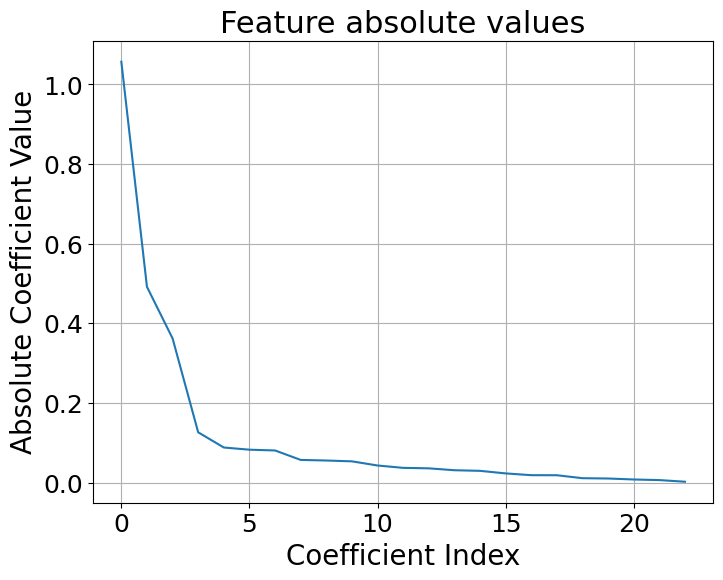

abs_coef: [0.01120453 0.08828473 0.03718988 0.05355578 1.05710762 0.0556175
 0.01880465 0.05714176 0.03598179 0.0431127  0.49182084 0.12644496
 0.0104346  0.08083886 0.36229727 0.08280474 0.01865423 0.03123137
 0.00236724 0.00798872 0.00645065 0.02969739 0.02324403]
sorted_abs_coef: [1.05710762 0.49182084 0.36229727 0.12644496 0.08828473 0.08280474
 0.08083886 0.05714176 0.0556175  0.05355578 0.0431127  0.03718988
 0.03598179 0.03123137 0.02969739 0.02324403 0.01880465 0.01865423
 0.01120453 0.0104346  0.00798872 0.00645065 0.00236724]
sorted_indices: [ 4 10 14 11  1 15 13  7  5  3  9  2  8 17 21 22  6 16  0 12 19 20 18]


In [113]:

abs_coef = np.abs(Huber_regressor_model.coef_)


sorted_indices = np.argsort(abs_coef)[::-1]

print(sorted_indices)
sorted_abs_coef = abs_coef[sorted_indices]
print(sorted_abs_coef)
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(range(len(sorted_indices)), sorted_abs_coef)
plt.xlabel('Coefficient Index')
plt.ylabel('Absolute Coefficient Value')
plt.title('Feature absolute values')
plt.grid(True)
plt.show()

print(f"abs_coef: {abs_coef}")
print(f"sorted_abs_coef: {sorted_abs_coef}")
print(f"sorted_indices: {sorted_indices}")

# Section 4: Feature Mappings (visualization)

In [114]:
train_df_prepared = prepare_data(train, train)
test_df_prepared = prepare_data(train, test)

y_train_section4 = train_df_prepared['contamination_level']
X_train_section4= train_df_prepared[['PCR_02', 'PCR_06']]
y_train_section4 = y_train_section4.to_numpy()
X_train_section4= X_train_section4.to_numpy()

y_test_section4 = test_df_prepared['contamination_level']
X_test_section4= test_df_prepared[['PCR_02', 'PCR_06']]
y_test_section4= y_test_section4.to_numpy()
X_test_section4= X_test_section4.to_numpy()

In [115]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

<ipython-input-115-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


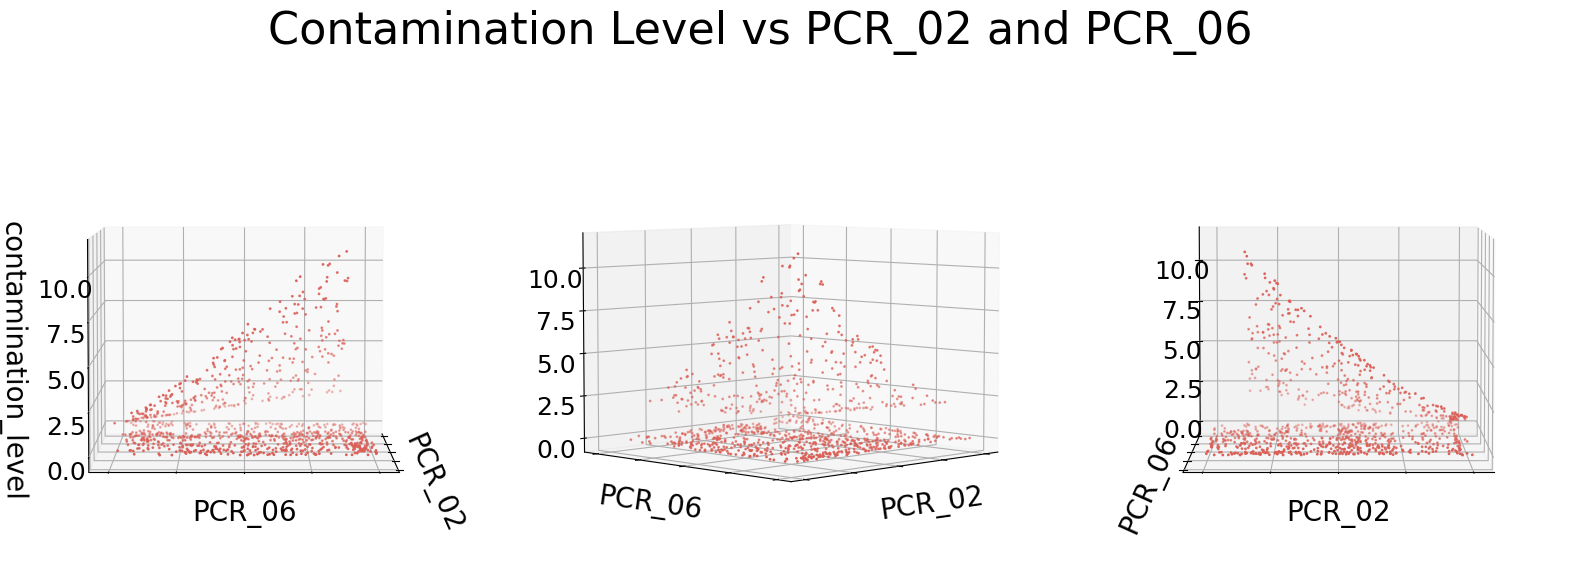

In [116]:
plot3d(train_df_prepared, 'PCR_02', 'PCR_06', 'contamination_level', 'Contamination Level vs PCR_02 and PCR_06')

In [117]:
best_lamda

29.3

**(Q15)**

In [118]:
# train an sklearn.linear_model.HuberRegressor with the optimal
# regularization strength found in (Q10)
delta_0_q_15= calculate_huber_delta(X_train_section4, y_train_section4)
Huber_regressor_model2 = HuberRegressor(alpha=best_lamda, epsilon=delta_0_q_15, fit_intercept=True)
Huber_regressor_model2.fit(X_train_section4, y_train_section4)

y_train_pred = Huber_regressor_model2.predict(X_train_section4)
y_test_pred = Huber_regressor_model2.predict(X_test_section4)

error_train_huber = huber_loss_metric(y_train_section3, y_train_pred, huber_delta0)

error_train_mse = mean_squared_error(y_train_section3, y_train_pred)

error_test_mse = mean_squared_error(y_test_section3, y_test_pred)
print(f"delta_0: {delta_0_q_15}")
print(f"Training Huber Loss: {error_train_huber}")
print(f"Training MSE: {error_train_mse}")
print(f"Test MSE: {error_test_mse}")

delta_0: 3.39
Training Huber Loss: 2.2622476779753633
Training MSE: 5.066776810489589
Test MSE: 4.930536273026795


<ipython-input-45-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


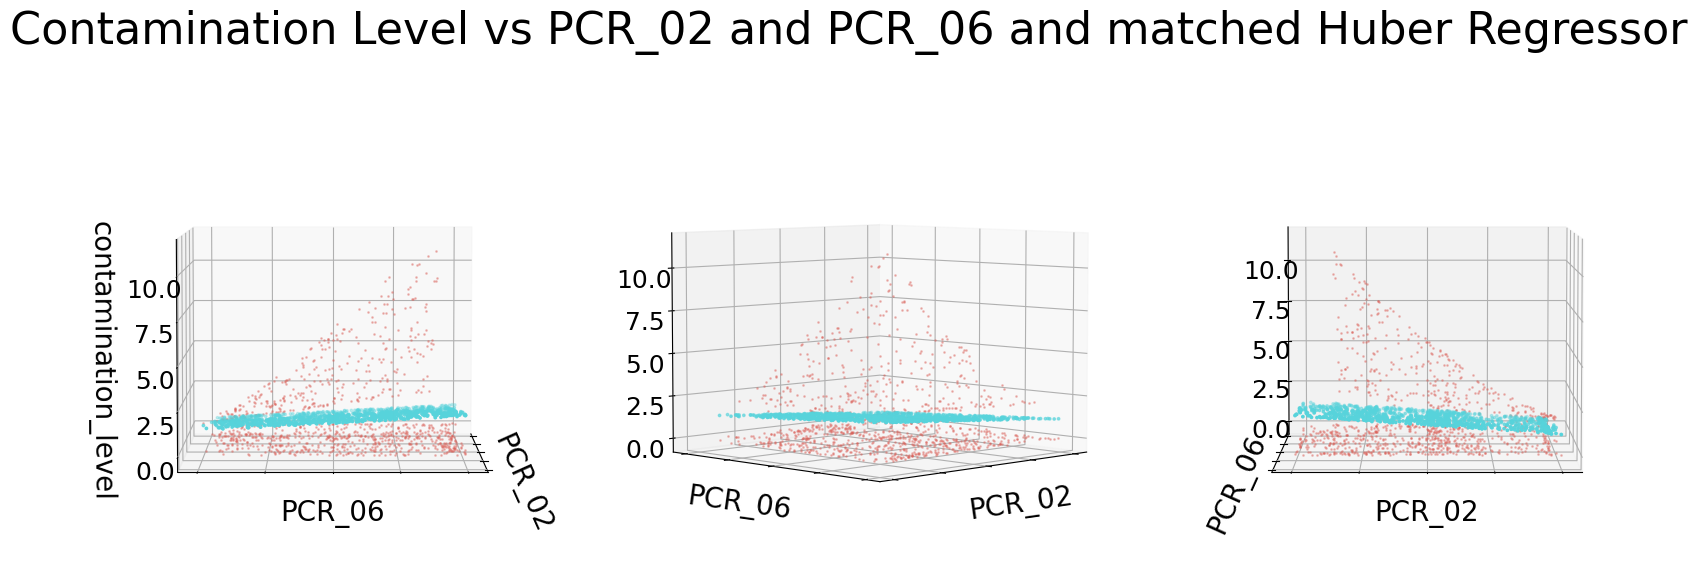

In [ ]:
plot3d(train_df_prepared, 'PCR_02', 'PCR_06', 'contamination_level', 'Contamination Level vs PCR_02 and PCR_06 and matched Huber Regressor', predictions=y_train_pred.tolist())

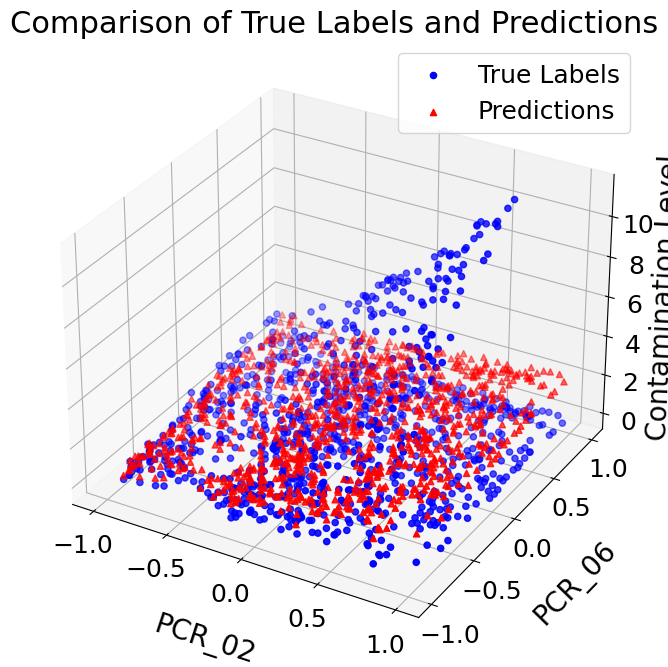

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

# Plot training samples and true labels
ax.scatter3D(X_train_section4[:, 0], X_train_section4[:, 1], y_train_section4, c='b', marker='o', label='True Labels')

# Plot model predictions
ax.scatter3D(X_train_section4[:, 0], X_train_section4[:, 1], y_train_pred, c='r', marker='^', label='Predictions')

# Set labels and title
ax.set_xlabel('PCR_02', labelpad=20)
ax.set_ylabel('PCR_06', labelpad=20)
ax.set_zlabel('Contamination Level')
ax.set_title('Comparison of True Labels and Predictions')
ax.legend()

plt.show()

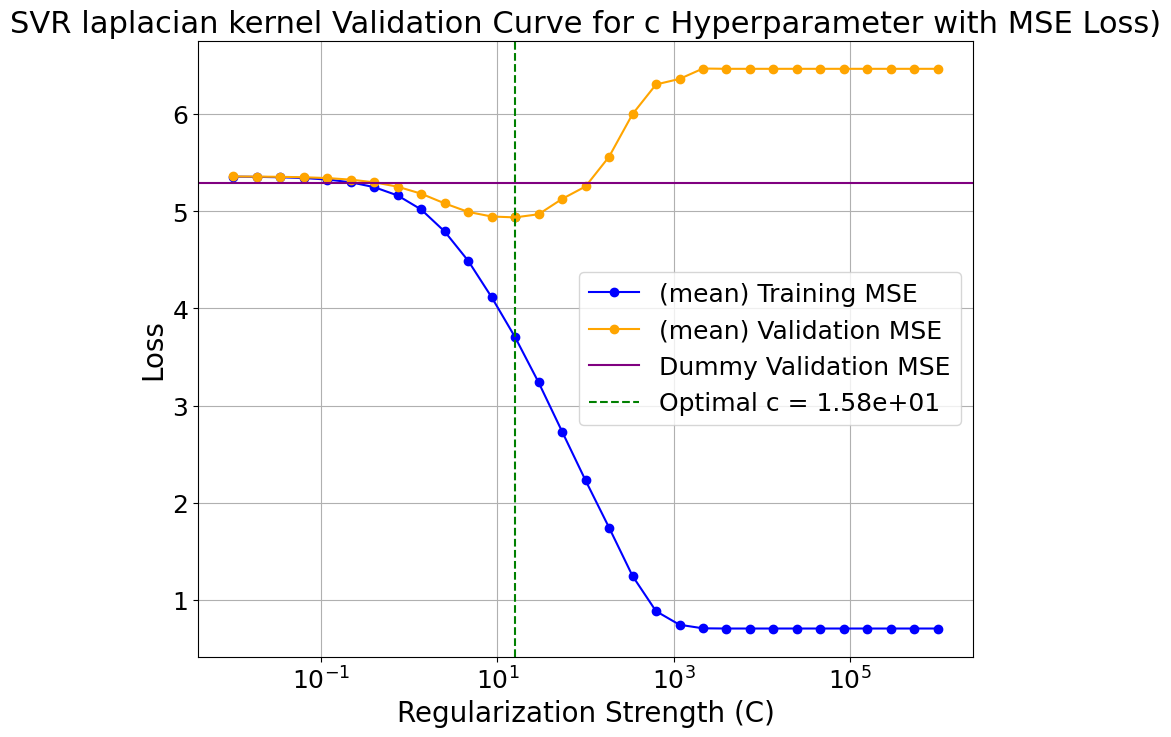

Optimal regularization strength (c): 1.58e+01
Training MSE loss at optimal c: 3.70(+/- 0.26)
Validation MSE loss at optimal c: 4.94(+/- 1.02)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics.pairwise import laplacian_kernel

C_values = np.logspace(-2, 6, num=31)
best_c = None
lowest_validation_mse = float('inf')
best_training_huber_loss = None
std_train_best = None
std_val_best = None
scores_validation_best = None

train_mean_huber_scores = []
train_mean_mse_scores = []
validation_mse_scores = []

scoring_metrics = {'MSE': 'neg_mean_squared_error'}

# Evaluate models for each c value
for c in C_values:
    #poly_reg = Pipeline([('normalization', MinMaxScaler(feature_range=(-1,1))),
     #     ('regressor', SVR(kernel=laplacian_kernel,tol=1e-5, C=c, epsilon=1))])

    poly_reg = SVR(kernel=laplacian_kernel,tol=1e-5, C=c, epsilon=1)
    scores = cross_validate(poly_reg, X_train_section4, y_train_section4, cv=5,
                            scoring=scoring_metrics, return_train_score=True)

    train_mse_score = np.mean(np.abs(scores['train_MSE']))
    train_mean_mse_scores.append(train_mse_score)

    validation_mse_score = np.mean(np.abs(scores['test_MSE']))
    validation_mse_scores.append(validation_mse_score)


    if validation_mse_score < lowest_validation_mse:
        best_c = c
        lowest_validation_mse = validation_mse_score
        lowest_training_mse = train_mse_score
        std_train_best = np.std(np.abs(scores['train_MSE']))
        std_val_best = np.std(np.abs(scores['test_MSE']))
        #scores_validation_best = np.abs(scores['test_MSE'])
        #scores_training_mse_best = np.abs(scores['train_MSE'])

# Plot the validation curve
plt.figure(figsize=(10, 8))
plt.semilogx(C_values, train_mean_mse_scores, label='(mean) Training MSE', color='blue', marker='o')
plt.semilogx(C_values, validation_mse_scores, label='(mean) Validation MSE', color='orange', marker='o')

plt.axhline(y=dummy_regressor_validation_mse, color='purple', label='Dummy Validation MSE')
plt.axvline(x=best_c, color='green', linestyle='--', label=f'Optimal c = {best_c:.2e}')
plt.scatter([best_c], [lowest_validation_mse], color='green')

plt.title(f'SVR laplacian kernel Validation Curve for c Hyperparameter with MSE Loss)')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal regularization strength (c): {best_c:.2e}")
print(f"Training MSE loss at optimal c: {lowest_training_mse:.2f}(+/- {std_train_best:.2f})")
print(f"Validation MSE loss at optimal c: {lowest_validation_mse:.2f}(+/- {std_val_best:.2f})")


In [ ]:
#cross valiation on the entire dataset

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR


poly_reg = SVR(kernel=laplacian_kernel,tol=1e-5, C=best_c, epsilon=1)
scores = cross_validate(poly_reg, X_train_section3, y_train_section3, cv=5,
                        scoring=scoring_metrics, return_train_score=True)

train_mse_score = np.mean(np.abs(scores['train_MSE']))

validation_mse_score = np.mean(np.abs(scores['test_MSE']))

print(np.abs(scores['train_MSE']))
print(f"Training MSE loss at optimal c: {train_mse_score :.2f}(+/- {std_train_best:.2f})")
print(f"Validation MSE loss at optimal c: {validation_mse_score:.2f}(+/- {std_val_best:.2f})")

[0.69831547 0.71441586 0.66358999 0.64131826 0.6457219 ]
Training MSE loss at optimal c: 0.67(+/- 0.10)
Validation MSE loss at optimal c: 2.57(+/- 1.00)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
print(best_c)
###### (Q20) #####
poly_reg = SVR(kernel=laplacian_kernel,tol=1e-5, C=best_c, epsilon=1)
poly_reg.fit(X_train_section3, y_train_section3)   #piazza @252 the scores you got from training on all of the data

y_train_pred = poly_reg.predict(X_train_section3)
y_test_pred = poly_reg.predict(X_test_section3)

error_train_mse = mean_squared_error(y_train_section3, y_train_pred)

error_test_mse = mean_squared_error(y_test_section3, y_test_pred)

print(f"Training MSE: {error_train_mse}")
print(f"Test MSE: {error_test_mse}")

15.848931924611142
Training MSE: 0.6788132238770891
Test MSE: 2.3622709697094715


<ipython-input-45-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


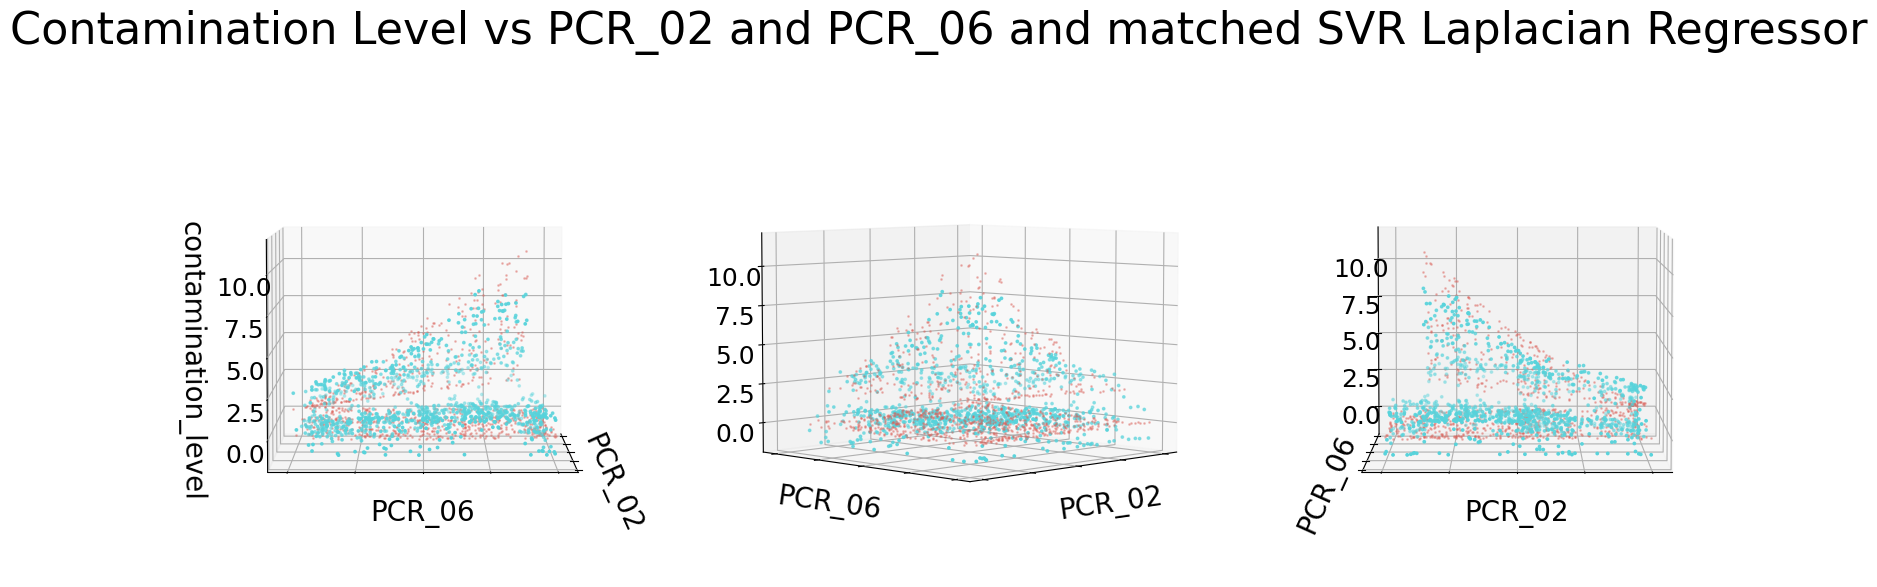

In [ ]:
plot3d(train_df_prepared, 'PCR_02', 'PCR_06', 'contamination_level', 'Contamination Level vs PCR_02 and PCR_06 and matched SVR Laplacian Regressor', predictions=y_train_pred.tolist())